In [33]:
%matplotlib inline
from detector import Detector
from utils import draw_bounding_boxes

In [34]:
test_image = "./images/test.jpg"
state_file = "./epoch_41.pth.tar"

In [35]:
detector = Detector(state_file)

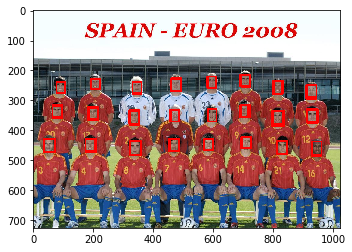

In [37]:
bboxes = detector.infer(test_image)
draw_bounding_boxes(test_image, bboxes)